<a href="https://colab.research.google.com/github/abhinayareddy1930/Breast-Tumour-Detection-using-DeepLearning/blob/main/modification_breast_tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import os

In [ ]:
BASE_PATH = '/content/Dataset_BUSI_with_GT'
unique_classes = [path for path in os.listdir(BASE_PATH) if not path.startswith('.')]

print(unique_classes)

['malignant', 'normal', 'benign']


In [ ]:
class_index = [unique_classes[0], unique_classes[2], unique_classes[1]]  # Rearranged order

for i, c in enumerate(class_index):
    print(c, "-", i)

malignant - 0
benign - 1
normal - 2


In [ ]:
images = []
masks = []
labels = []
for folder in os.listdir(BASE_PATH):
    class_path = os.path.join(BASE_PATH, folder)
    for img in os.listdir(class_path):
        if "_mask" not in img:
            img_path = os.path.join(class_path, img)
            msk_path = img_path.replace(".png", "_mask.png")
            # check if mask exist
            if os.path.exists(msk_path):
                images.append(img_path)
                masks.append(msk_path)
                labels.append(folder)

In [ ]:
print(len(images))

780


In [ ]:
images[0]

'/content/Dataset_BUSI_with_GT/malignant/malignant (22).png'

In [ ]:
input_images_size = 256
channel = 1

In [ ]:
import cv2
import scipy
import scipy.ndimage


def load_image(img_path):
    """ Load single image as Grayscale
    """
    # load image as grayscale
    img = cv2.imread(img_path, 0)
    return img

def padding(img, msk):
    """ Pad images to make them square
    """
    size = np.max(img.shape)

    offset_x = (size-img.shape[0])//2
    offset_y = (size-img.shape[1])//2
    blank_image = np.zeros((size, size))
    blank_mask = np.zeros((size, size))

    blank_image[offset_x:offset_x+img.shape[0],
               offset_y:offset_y+img.shape[1]] = img
    blank_mask[offset_x:offset_x+img.shape[0],
               offset_y:offset_y+img.shape[1]] = msk
    return blank_image, blank_mask

def resize_mask(mask):
    """Resize mask, its different because mask pixel value can change because of resize
    """
    new_size = np.array([input_images_size, input_images_size]) / mask.shape
    mask = scipy.ndimage.interpolation.zoom(mask, new_size)
    return mask

def resize(img):
    """Resize image
    """
    img = cv2.resize(img, (input_images_size, input_images_size))
    return img
def preprocess(img):
  img = img/255.0
  return img

def inverse_preprocess(img):
    """Inverse of preprocessing
    """
    img = img*255
    return img
def load_data(img_path, msk_path, label):
    """Load image, mask and repalce mask value with class index
    0 = normal
    1 = benign
    2 = malignant
    """
    img = load_image(img_path)
    msk = load_image(msk_path)
    img, msk = padding(img, msk)
    label_indx = class_index.index(label)
    msk[msk == 255] = 1
    msk = msk.astype("uint8")
    img = resize(img)
    msk = resize_mask(msk)
    new_mask = np.zeros((input_images_size, input_images_size, 2))
    if label_indx != 0:
        new_mask[:, :, label_indx-1] = msk
#     print(np.unique(msk), label, label_indx)
    return img, new_mask
def load_batch(images, masks, labels):
    """Load Batch of data
    """
    batch_x = []
    batch_y = []
    for i, m, l in zip(images, masks, labels):
        img, msk = load_data(i, m, l)
        img = preprocess(img)
        batch_x.append(img)
        batch_y.append(msk)
    return np.array(batch_x), np.array(batch_y)

<ipython-input-8-2ccde7da84cf>:33: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  mask = scipy.ndimage.interpolation.zoom(mask, new_size)


0.0 255.0 (256, 256)


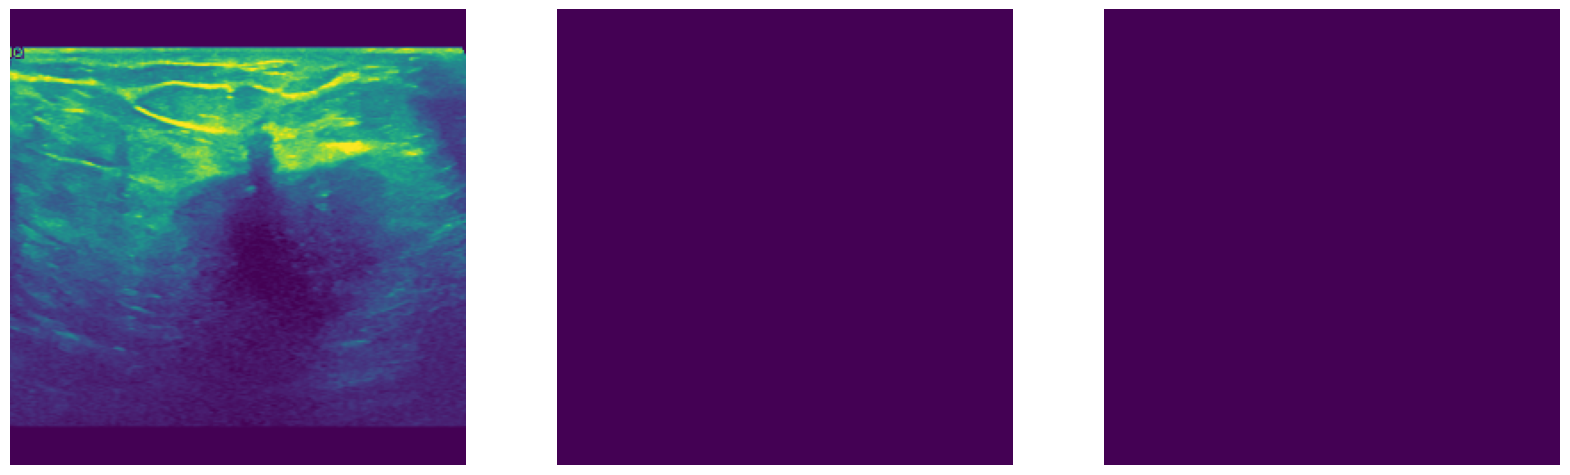

0.0 247.10430908203125 (256, 256)


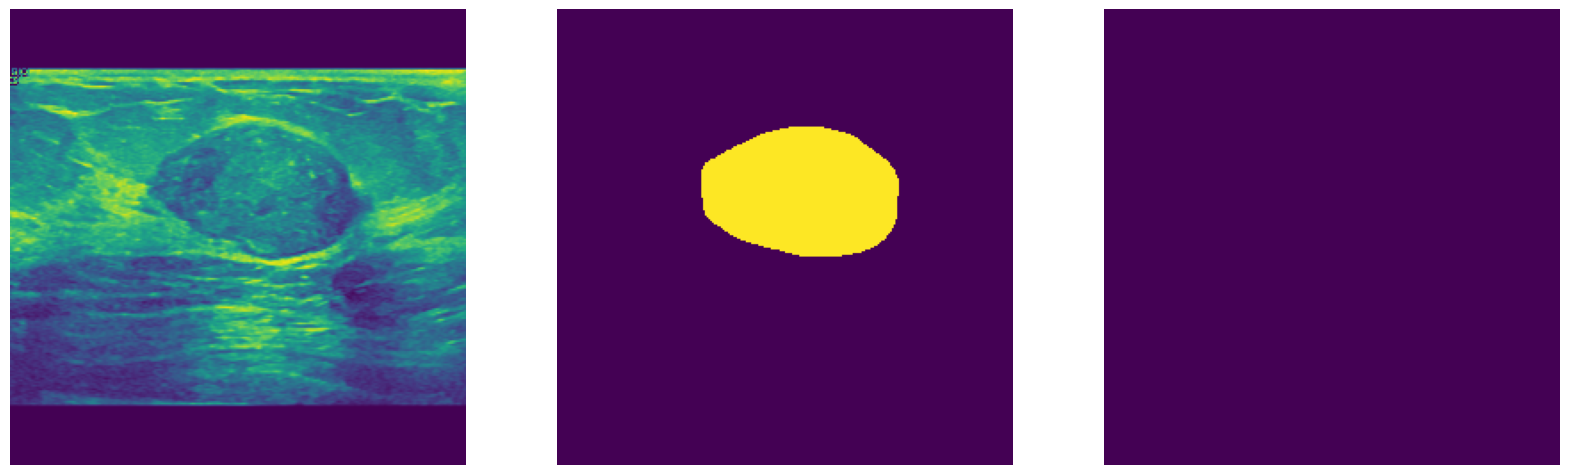

0.0 239.40977096557617 (256, 256)


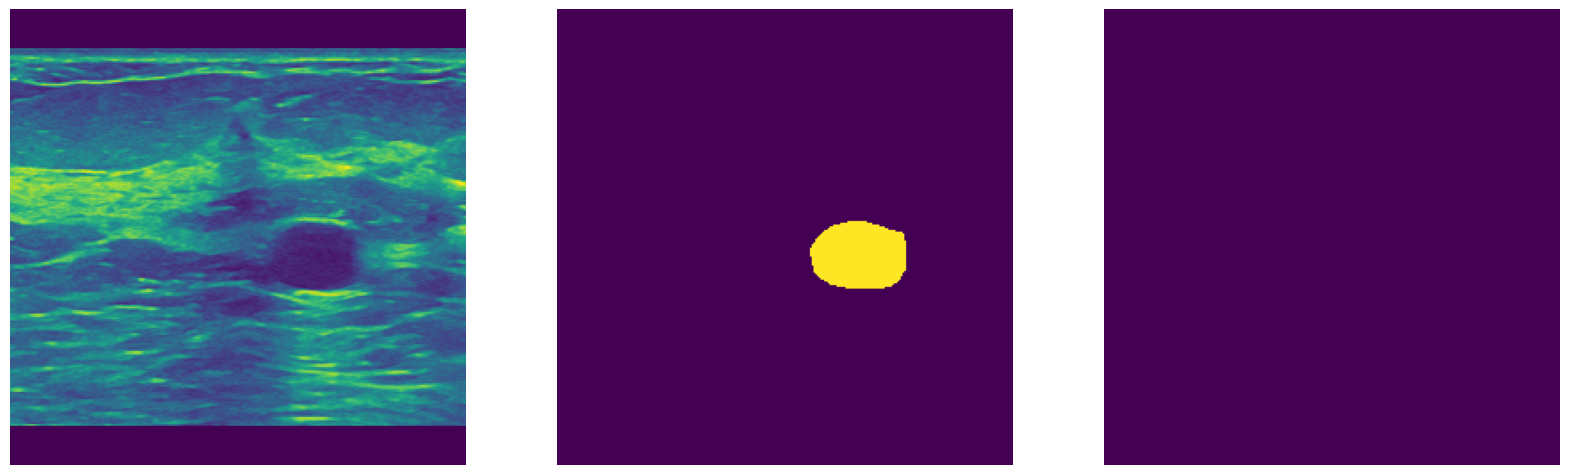

In [ ]:
import matplotlib.pyplot as plt
for i in [0, 500, 600]:
    indx = i
    img, msk = load_data(images[indx], masks[indx], labels[indx])
    print(np.min(img), np.max(img), img.shape)
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 3, 1)
    plt.axis("off")
    plt.imshow(img)
    plt.subplot(1, 3, 2)
    plt.axis("off")
    plt.imshow(msk[:, :, 0])
    plt.subplot(1, 3, 3)
    plt.axis("off")
    plt.imshow(msk[:, :, 1])
    plt.show()

In [ ]:
images = np.array(images)
masks = np.array(masks)
labels = np.array(labels)

In [ ]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [ ]:
!pip install tensorflow keras segmentation-models

In [ ]:
!pip install tensorflow==2.12.0
!pip install keras==2.12.0

!pip install segmentation-models

In [ ]:
import segmentation_models as sm
import tensorflow as tf
sm.set_framework('tf.keras')

sm.framework()

BACKBONE = 'resnet34'
LR = 0.00001
model = sm.Unet(BACKBONE, classes=2, activation="sigmoid",
                input_shape=(input_images_size,
                             input_images_size, channel),
                encoder_weights=None)

optim = tf.keras.optimizers.Adam(LR)

dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
metrics = [sm.metrics.IOUScore(threshold=0.5),
           sm.metrics.FScore(threshold=0.5)]

model.compile(optim, total_loss, metrics)

Segmentation Models: using `tf.keras` framework.


In [ ]:
batch_size = 64
history = {"epoch": []}

for e in range(5):
    print("epoch:", e, end=" > ")
    indexes = list(range(len(images)))
    temp_history = {"loss": [], "IOU": [], "F-Score": []}

    for b in range(0, len(images), batch_size):
        # Avoid out-of-bounds error by ensuring the last batch is valid
        batch_index = indexes[b: min(b + batch_size, len(images))]  # Use min to avoid exceeding the dataset length

        # Loading the batch
        batch_x, batch_y = load_batch(images[batch_index], masks[batch_index], labels[batch_index])
        batch_x = np.expand_dims(batch_x, axis=-1)
        batch_y = np.expand_dims(batch_y, axis=-1)
        batch_y = batch_y.astype("float32")

        # Train on batch
        loss = model.train_on_batch(batch_x, batch_y)

        # Append loss & metrics
        temp_history["loss"].append(loss[0])
        temp_history["IOU"].append(loss[1])
        temp_history["F-Score"].append(loss[2])

    # Print epoch stats
    print("loss", np.round(np.mean(temp_history["loss"]), 4),
          "IOU", np.round(np.mean(temp_history["IOU"]), 4),
          "F-Score", np.round(np.mean(temp_history["F-Score"]), 4))

    history["epoch"].append(temp_history)

# Save model weights
model.save_weights("breast_tumor_segmentation")



epoch: 0 > 

<ipython-input-8-2ccde7da84cf>:33: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  mask = scipy.ndimage.interpolation.zoom(mask, new_size)


loss 1.1377 IOU 0.0164 F-Score 0.0311
epoch: 1 > loss 1.1232 IOU 0.0187 F-Score 0.0353
epoch: 2 > loss 1.1117 IOU 0.02 F-Score 0.0376
epoch: 3 > loss 1.102 IOU 0.0211 F-Score 0.0394
epoch: 4 > loss 1.0935 IOU 0.0223 F-Score 0.0415


<ipython-input-8-2ccde7da84cf>:33: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  mask = scipy.ndimage.interpolation.zoom(mask, new_size)


0.0 255.0 (256, 256)
(256, 256)
1/1 [==============================] - 2s 2s/step


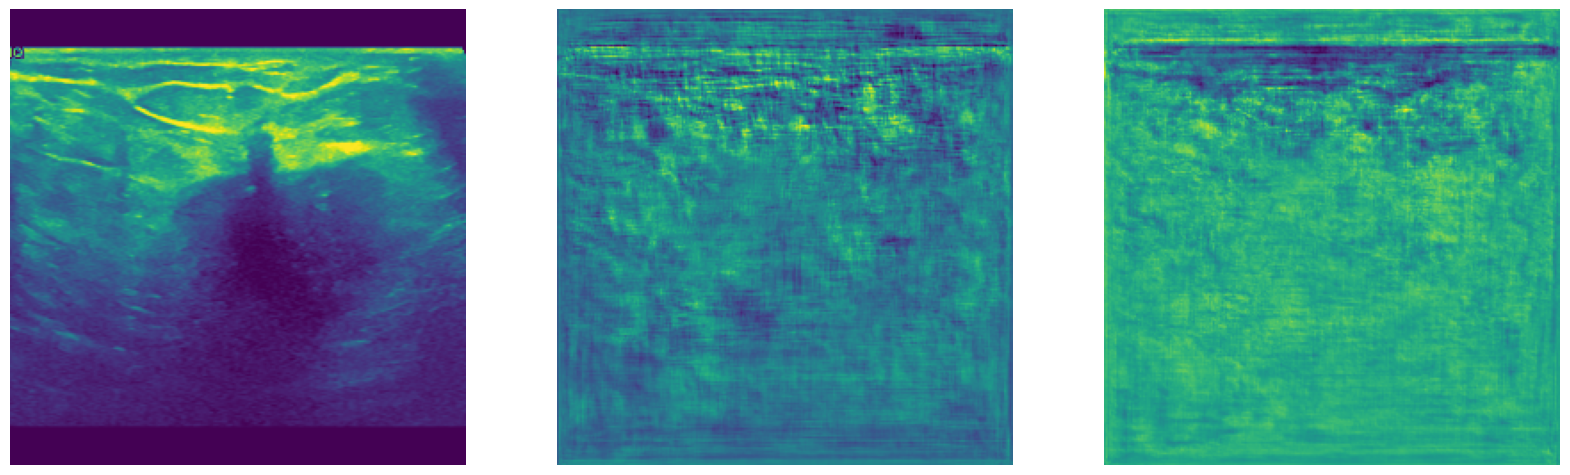

0.0 247.10430908203125 (256, 256)
(256, 256)
1/1 [==============================] - 0s 420ms/step


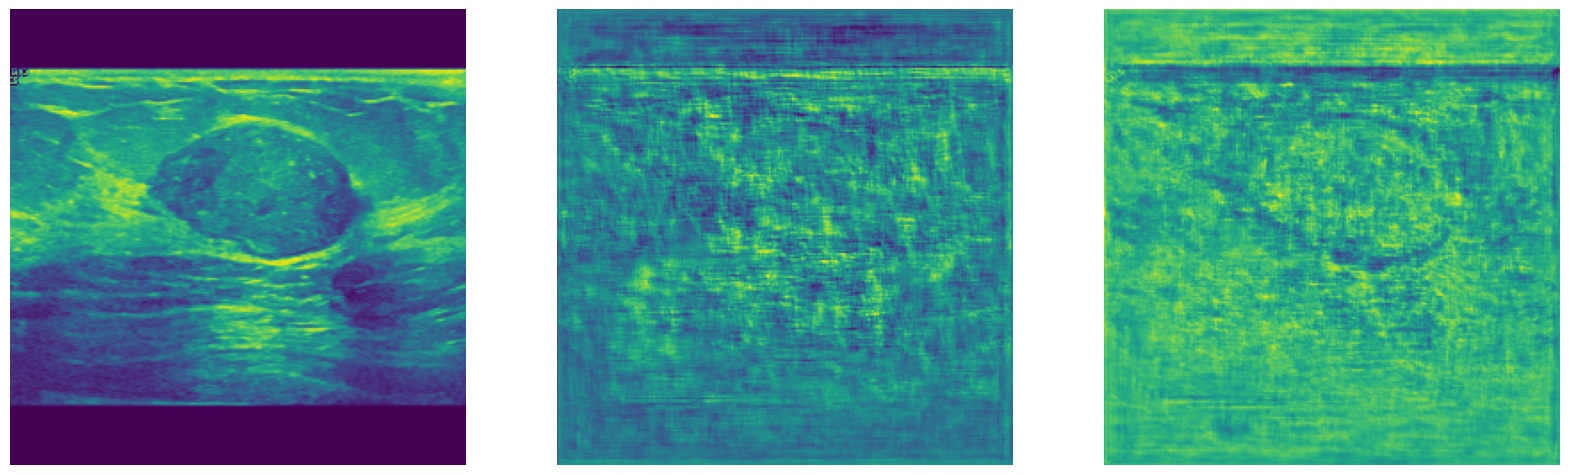

0.0 239.40977096557617 (256, 256)
(256, 256)
1/1 [==============================] - 0s 420ms/step


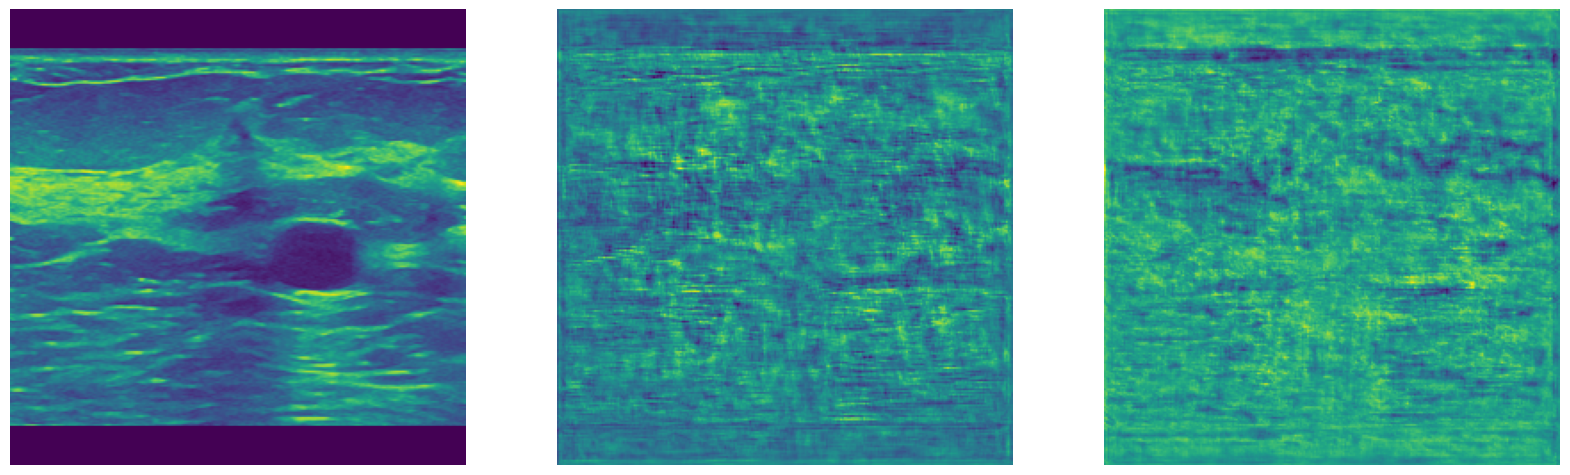

In [ ]:
import matplotlib.pyplot as plt
for i in [0, 500, 600]:
    indx = i
    img, msk = load_data(images[indx], masks[indx], labels[indx])
    print(np.min(img), np.max(img), img.shape)
    print(img.shape)

    img2 = preprocess(img)
    pred = model.predict(np.array([img2]))
    pred = pred[0]

    plt.figure(figsize=(20, 20))
    plt.subplot(1, 3, 1)
    plt.axis("off")
    plt.imshow(img)
    plt.subplot(1, 3, 2)
    plt.axis("off")
    plt.imshow(pred[:, :, 0])
    plt.subplot(1, 3, 3)
    plt.axis("off")
    plt.imshow(pred[:, :, 1])
    plt.show()

In [ ]:
import numpy as np
import cv2

def extract_tumor_features(mask):
    """Extract features from the tumor mask."""
    # Calculate tumor area (number of pixels)
    tumor_area = np.sum(mask > 0)

    # Calculate tumor bounding box and size
    coords = np.column_stack(np.where(mask > 0))
    if len(coords) > 0:
        x, y, w, h = cv2.boundingRect(coords)
        tumor_size = max(w, h)  # Maximum dimension of the tumor
        circularity = (4 * np.pi * tumor_area) / (cv2.arcLength(coords, True) ** 2)  # Circularity measure
    else:
        tumor_size = 0
        circularity = 0

    return {
        'tumor_area': tumor_area,
        'tumor_size': tumor_size,
        'circularity': circularity
    }

In [ ]:
def predict_stage_and_risk(features):
    """Predict cancer stage and risk level based on tumor features."""
    tumor_size = features['tumor_size']

    # Rule-based stage prediction
    if tumor_size == 0:
        stage = 'Normal'
        risk = 'None'  # No risk if normal
    elif tumor_size < 30:
        stage = 'Stage I'
        risk = 'Low'  # Stage I = Low Risk
    elif tumor_size < 70:
        stage = 'Stage II'
        risk = 'Medium'  # Stage II = Medium Risk
    else:
        stage = 'Stage III'
        risk = 'High'  # Stage III = High Risk

    return stage, risk

In [ ]:
for i in [10,250,300,500]:  # Example indices
    img, msk = load_data(images[i], masks[i], labels[i])
    features = extract_tumor_features(msk[:, :, 0] + msk[:, :, 1])  # Combine both masks if needed
    stage, risk = predict_stage_and_risk(features)

    print(f"Image {i}:")
    print(f"Tumor Features: {features}")
    print(f"Predicted Stage: {stage}, Predicted Risk: {risk}")
    print("-" * 40)

Image 10:
Tumor Features: {'tumor_area': 0, 'tumor_size': 0, 'circularity': 0}
Predicted Stage: Normal, Predicted Risk: None
----------------------------------------
Image 250:
Tumor Features: {'tumor_area': 0, 'tumor_size': 0, 'circularity': 0}
Predicted Stage: Normal, Predicted Risk: None
----------------------------------------
Image 300:
Tumor Features: {'tumor_area': 0, 'tumor_size': 0, 'circularity': 0}
Predicted Stage: Normal, Predicted Risk: None
----------------------------------------
Image 500:
Tumor Features: {'tumor_area': 6457, 'tumor_size': 111, 'circularity': 0.0004939262633599574}
Predicted Stage: Stage III, Predicted Risk: High
----------------------------------------


<ipython-input-8-2ccde7da84cf>:33: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  mask = scipy.ndimage.interpolation.zoom(mask, new_size)


<ipython-input-8-2ccde7da84cf>:33: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  mask = scipy.ndimage.interpolation.zoom(mask, new_size)


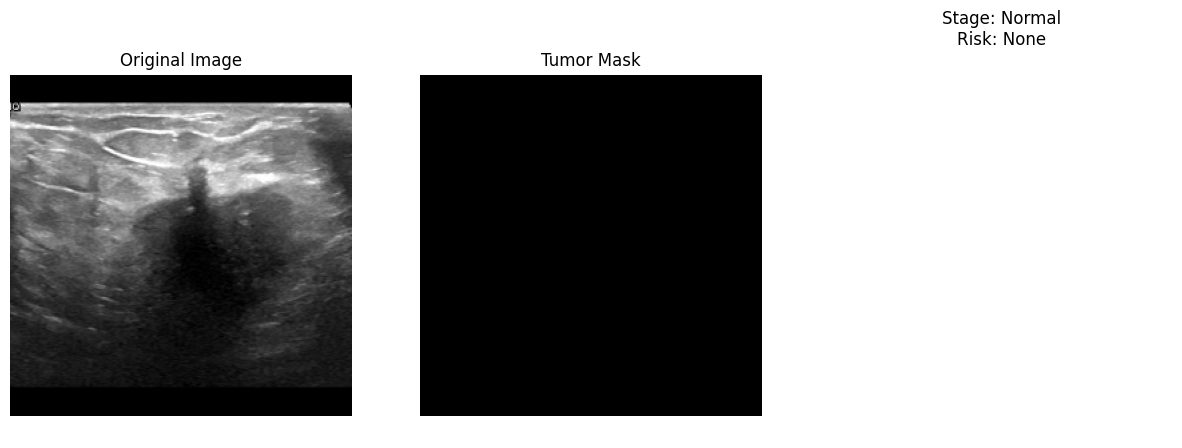

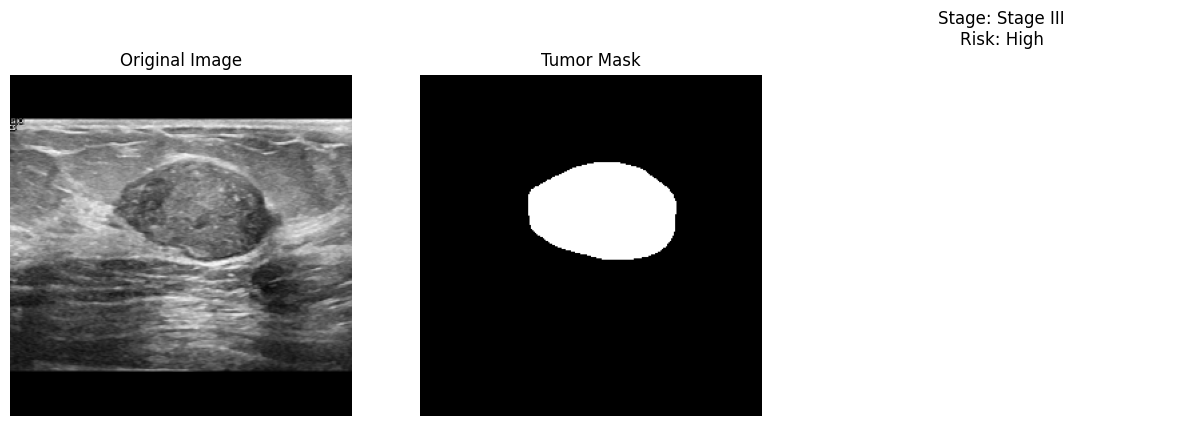

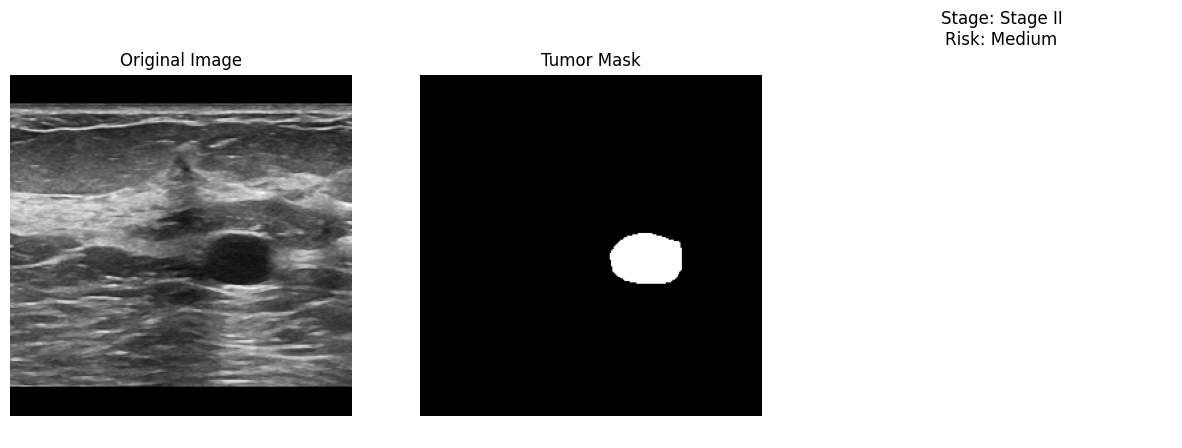

In [ ]:
import matplotlib.pyplot as plt

for i in [0, 500, 600]:  # Example indices
    img, msk = load_data(images[i], masks[i], labels[i])
    features = extract_tumor_features(msk[:, :, 0] + msk[:, :, 1])
    stage, risk = predict_stage_and_risk(features)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(img, cmap='gray')
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Tumor Mask")
    plt.imshow(msk[:, :, 0] + msk[:, :, 1], cmap='gray')
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title(f"Stage: {stage}\nRisk: {risk}")
    plt.axis("off")
    plt.show()

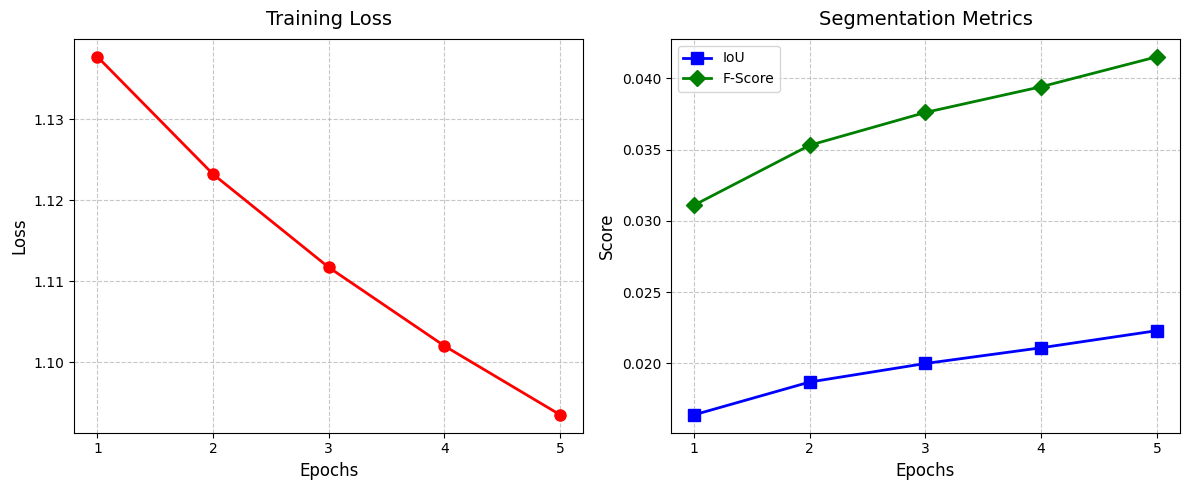

In [ ]:
#training progress visualization
import matplotlib.pyplot as plt
import numpy as np

# Your actual metrics
epochs = [1, 2, 3, 4, 5]
loss = [1.1377, 1.1232, 1.1117, 1.1020, 1.0935]
iou = [0.0164, 0.0187, 0.0200, 0.0211, 0.0223]
fscore = [0.0311, 0.0353, 0.0376, 0.0394, 0.0415]

plt.figure(figsize=(12, 5))

# Loss subplot
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'r-o', linewidth=2, markersize=8)
plt.title('Training Loss', fontsize=14, pad=10)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(epochs)

# Metrics subplot
plt.subplot(1, 2, 2)
plt.plot(epochs, iou, 'b-s', linewidth=2, markersize=8, label='IoU')
plt.plot(epochs, fscore, 'g-D', linewidth=2, markersize=8, label='F-Score')
plt.title('Segmentation Metrics', fontsize=14, pad=10)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.xticks(epochs)

plt.tight_layout()
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

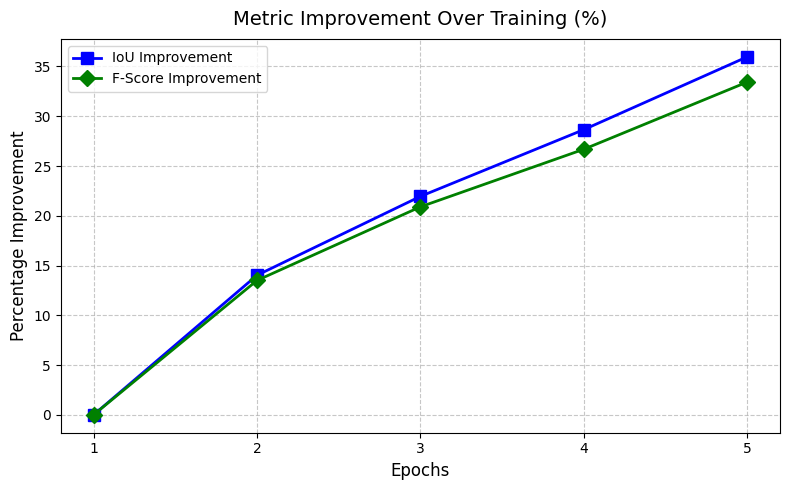

In [ ]:
#metric improvement rates
# Calculate percentage improvements
iou_improvement = [((iou[i]-iou[0])/iou[0])*100 for i in range(len(iou))]
fscore_improvement = [((fscore[i]-fscore[0])/fscore[0])*100 for i in range(len(fscore))]

plt.figure(figsize=(8, 5))
plt.plot(epochs, iou_improvement, 'b-s', linewidth=2, markersize=8, label='IoU Improvement')
plt.plot(epochs, fscore_improvement, 'g-D', linewidth=2, markersize=8, label='F-Score Improvement')
plt.title('Metric Improvement Over Training (%)', fontsize=14, pad=10)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Percentage Improvement', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(epochs)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig('metric_improvement.png', dpi=300, bbox_inches='tight')
plt.show()

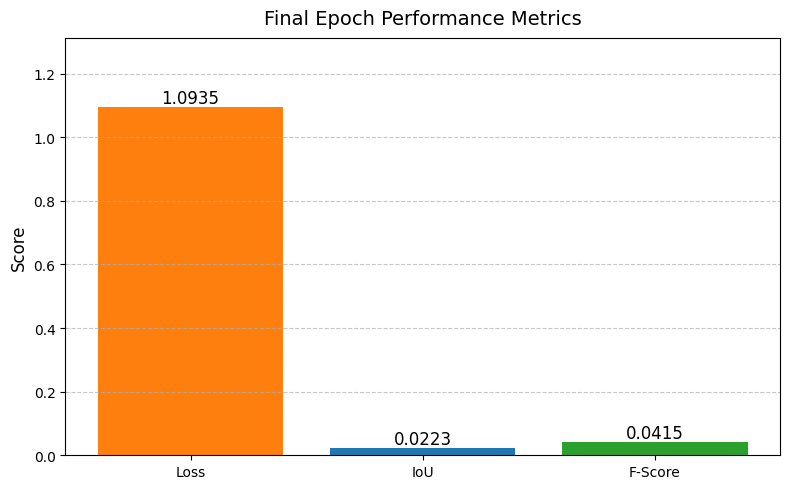

In [ ]:
#epoch performance breakdown
# Data for the last epoch
metrics = ['Loss', 'IoU', 'F-Score']
values = [loss[-1], iou[-1], fscore[-1]]
colors = ['#ff7f0e', '#1f77b4', '#2ca02c']

plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, values, color=colors)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=12)

plt.title('Final Epoch Performance Metrics', fontsize=14, pad=10)
plt.ylabel('Score', fontsize=12)
plt.ylim(0, max(values)*1.2)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('final_metrics.png', dpi=300, bbox_inches='tight')
plt.show()